# Machine Learning Models for CPI and binding affinity

The identification of compound-protein interactions (CPIs) is a crucial step in the process of drug discovery.  Compounds and proteins do not simply interact, they bind at a particular strength known as binding affinity.  Since the laboratory determination of CPIs is costly and time-consuming, computer science has become a promising and efficient alternative for predicting novel interactions between compounds and proteins on a large scale.

This notebook explores various machine learning models for predicting CPI interaction (the classification models) and binding affinity (the regression models).

Enjoy.

## Part 1: Prepare the development environment.

In [1]:
from IPython.core.pylabtools import figsize
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn import linear_model, metrics
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, LogisticRegression, Perceptron
from sklearn.model_selection import train_test_split,GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, classification_report, mean_squared_error, r2_score
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier,MLPRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.svm import SVR
import time
import warnings

## Part 2: Tokenize the datasets (both compounds and proteins are trained with a language model to learn the dependencies between the amino acids) before training the machine learning models.

In [2]:
def token(data):
  model_checkpoint = "facebook/esm2_t12_35M_UR50D"
  from transformers import AutoTokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
  y=data.iloc[:, -1]
  print("labels:", y.shape)
# before alignment
  fingerprint = []
  adjacency = []
  sequence = []
  for i in range(len(data)):
    compound, protein, interaction = data.iloc[i, :]

    mol = Chem.AddHs(Chem.MolFromSmiles(compound))
    adjacency.append( np.array(Chem.GetAdjacencyMatrix(mol)).flatten())
    fingerprint.append(np.array([int(i) for i in AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024, useChirality=True).ToBitString()]))
    sequence.append( np.array(tokenizer(protein,padding='max_length')['input_ids']))
# alignments
  adjacency =pd.DataFrame(adjacency)
  adjacency= adjacency.fillna(0)

  sequence =pd.DataFrame(sequence)
  sequence= sequence.fillna(0)
# after alignments, combine different parts of data
  fingerprint=pd.DataFrame(fingerprint)
  X = pd.concat([fingerprint, adjacency,sequence], axis=1)
  print("dataset:", X.shape)
  return X, y

def token_simple(data):
  model_checkpoint = "facebook/esm2_t12_35M_UR50D"
  from transformers import AutoTokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
  y=data.iloc[:, -1]
  print("labels:", y.shape)
# before alignment
  fingerprint = []
  sequence = []
  for i in range(len(data)):
    compound, protein, interaction = data.iloc[i, :]

    mol = Chem.AddHs(Chem.MolFromSmiles(compound))
    fingerprint.append(np.array([int(i) for i in AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024, useChirality=True).ToBitString()]))
    sequence.append( np.array(tokenizer(protein,padding='max_length')['input_ids']))
# alignments
  sequence =pd.DataFrame(sequence)
  sequence= sequence.fillna(0)
# after alignments, combine different parts of data
  fingerprint=pd.DataFrame(fingerprint)
  X = pd.concat([fingerprint, sequence], axis=1)
  print("dataset:", X.shape)
  print("Number of positive/negative labels:", y.value_counts())
  return X, y

def token_poly(data):
  y=data.iloc[:, -1]
  print("labels:", y.shape)
  fingerprint = []
  for i in range(len(data)):
    compound, protein, interaction = data.iloc[i, :]
    mol = Chem.AddHs(Chem.MolFromSmiles(compound))
    fingerprint.append(np.array([int(i) for i in AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=64, useChirality=True).ToBitString()]))
# after alignments
  X=pd.DataFrame(fingerprint)
  print("dataset:", X.shape)
  return X, y

### Future Work

In [3]:
# apply different protein tokenization for different models
ESM_models = ['facebook/esm2_t48_15B_UR50D', 'facebook/esm2_t36_3B_UR50D', 'facebook/esm2_t33_650M_UR50D', 'facebook/esm2_t30_150M_UR50D', 'facebook/esm2_t12_35M_UR50D', 'facebook/esm2_t6_8M_UR50D']

# apply different fingerprint algorithms for the compounds 
fpgen1 = AllChem.GetRDKitFPGenerator()
fpgen2 = AllChem.GetAtomPairGenerator()
fpgen3 = AllChem.GetMorganGenerator(radius=2)

# fairness: with different ratios of positive and negative samples for CPIs prediction.
#dataset_0 = dataset.['interaction' = 0][0:1000]
#dataset_1 = dataset.['interaction' = 1][0:1000]

##  Part 3: Supervised Models Comparison

In [4]:
# change the directory to that of the CSV files.

current = os.getcwd()
os.chdir('../data/csv/')

print(os.getcwd())

C:\Users\rabin badree\OneDrive\Documents\badreeRoziena\machineLearning\project\github\data\csv


### 3.1 Regression models

In [5]:
# data processing
data = pd.read_csv('test_EC50.csv', header=None)
X, y = token(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Ridge
reg = linear_model.Ridge(alpha=.1)
reg = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
test_rmse_ridge=math.sqrt(mean_squared_error(y_test, y_pred))
test_r2_ridge = r2_score(y_test, y_pred)

# Lasso
clf = linear_model.Lasso(alpha=.1)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
test_rmse_lasso=math.sqrt(mean_squared_error(y_test, y_pred))
test_r2_lasso = r2_score(y_test, y_pred)

# SVM
svm = SVR(kernel='rbf',C=1000, gamma=0.1)
svm.fit(X_train, y_train)
y_test_predicted_svm = svm.predict(X_test)
test_rmse_svm = math.sqrt(mean_squared_error(y_test, y_test_predicted_svm))
test_r2_svm = r2_score(y_test, y_test_predicted_svm)

# Random Forest
rnd_forest_reg = RandomForestRegressor(n_estimators=500,  criterion='squared_error',max_features="auto", verbose=1, max_depth=20, n_jobs=-1)
rnd_forest_reg.fit(X_train, y_train)
y_pred = rnd_forest_reg.predict(X_test)
test_rmse_rf=math.sqrt(mean_squared_error(y_test, y_pred))
test_r2_rf = r2_score(y_test, y_pred)

data = [
        ["Ridge Linear Regression", test_rmse_ridge, test_r2_ridge], 
        ["Lasso Linear Regression", test_rmse_lasso, test_r2_lasso],
        ["Support Vector Machine (Gaussian RBF)", test_rmse_svm, test_r2_svm],
        ["Random Forest", test_rmse_rf, test_r2_rf]
       ]


pd.DataFrame(data, columns=["Model", "RMSE", "R2 Score"])

labels: (11483,)
dataset: (11483, 17654)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 21.3min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


,Model,RMSE,R2 Score
0,Ridge Linear Regression,1.830069,-0.437093
1,Lasso Linear Regression,0.997807,0.572788
2,Support Vector Machine (Gaussian RBF),1.509745,0.021959
3,Random Forest,0.807928,0.719911


In [6]:
# data processing
data = pd.read_csv('test_EC50.csv', header=None)
data = data.sample(frac=1)
X, y = token_simple(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Ridge
reg = linear_model.Ridge(alpha=.1)
reg = reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
test_rmse_ridge=math.sqrt(mean_squared_error(y_test, y_pred))
test_r2_ridge = r2_score(y_test, y_pred)

# Lasso
clf = linear_model.Lasso(alpha=.1)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
test_rmse_lasso=math.sqrt(mean_squared_error(y_test, y_pred))
test_r2_lasso = r2_score(y_test, y_pred)

# SVM
svm = SVR(kernel='rbf',C=1000, gamma=0.1)
svm.fit(X_train, y_train)
y_test_predicted_svm = svm.predict(X_test)
test_rmse_svm = math.sqrt(mean_squared_error(y_test, y_test_predicted_svm))
test_r2_svm = r2_score(y_test, y_test_predicted_svm)

# Random Forest
rnd_forest_reg = RandomForestRegressor(n_estimators=500,  criterion='squared_error',verbose=1, max_depth=20, n_jobs=-1)
rnd_forest_reg.fit(X_train, y_train)
y_pred = rnd_forest_reg.predict(X_test)
test_rmse_rf=math.sqrt(mean_squared_error(y_test, y_pred))
test_r2_rf = r2_score(y_test, y_pred)

# MLP regressor
MLP_reg = MLPRegressor(random_state=1, max_iter=500)
MLP_reg.fit(X_train, y_train)
y_pred = MLP_reg.predict(X_test)
test_rmse_MLP=math.sqrt(mean_squared_error(y_test, y_pred))
test_r2_MLP = r2_score(y_test, y_pred)

data = [
        ["Ridge Linear Regression", test_rmse_ridge, test_r2_ridge], 
        ["Lasso Linear Regression", test_rmse_lasso, test_r2_lasso],
        ["Support Vector Machine (Gaussian RBF)", test_rmse_svm, test_r2_svm],
        ["Random Forest", test_rmse_rf, test_r2_rf],
        ["MLP",test_rmse_MLP, test_r2_MLP]
       ]


pd.DataFrame(data, columns=["Model", "RMSE", "R2 Score"])

labels: (11483,)
dataset: (11483, 2525)
Number of positive/negative labels: 3.823909    480
4.522879    256
3.522879    189
4.004365     71
6.698970     64
           ... 
5.527244      1
4.870955      1
4.668694      1
4.099087      1
4.549489      1
Name: 2, Length: 4563, dtype: int64


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  7.0min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    0.1s finished


,Model,RMSE,R2 Score
0,Ridge Linear Regression,0.949984,0.590964
1,Lasso Linear Regression,1.013284,0.534638
2,Support Vector Machine (Gaussian RBF),1.186531,0.361903
3,Random Forest,0.792437,0.715385
4,MLP,0.917291,0.618633


### 3.2 Hyperparameter Tuning for Stochastic Gradient Descent

In [7]:
# %%time
warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'alpha': [0.1, 0.01, 0.001], 'learning_rate': ["constant", "optimal", "invscaling"], 
              'l1_ratio': [1, 0.2, 0], 'max_iter':[100, 400, 1000],'eta0': [0.01, 0.001, 0.0001], 'penalty':['l2', 'l1', 'elasticnet']}

sgd = SGDRegressor()
sgd_cv = GridSearchCV(sgd, param_grid, cv=2, n_jobs=-1)
sgd_cv.fit(X_train[:1000], y_train[:1000])

params_optimal_sgd = sgd_cv.best_params_

print("Best Score in SGD: %f" % sgd_cv.best_score_)
print("Optimal Hyperparameter Values in SGD: ", params_optimal_sgd)
print("\n")

# test the model
lin_reg_sgd = SGDRegressor(**params_optimal_sgd)
lin_reg_sgd.fit(X_train, y_train)
y_test_predicted = lin_reg_sgd.predict(X_test)

print("Root Mean squared error in SGD: %.2f" %math.sqrt(mean_squared_error(y_test, y_test_predicted)))
print("Coefficient of determination r^2 variance score [1 is perfect prediction] in SGD: %.2f"  % r2_score(y_test, y_test_predicted))

Best Score in SGD: -248287785894435424.000000
Optimal Hyperparameter Values in SGD:  {'alpha': 0.1, 'eta0': 0.0001, 'l1_ratio': 0.2, 'learning_rate': 'invscaling', 'max_iter': 100, 'penalty': 'l1'}


Root Mean squared error in SGD: 486037551.49
Coefficient of determination r^2 variance score [1 is perfect prediction] in SGD: -107070091888260864.00


### 3.3 Polynomial degree:  used to find out the coefficiency between binding affinity and drugs, which means a particular characteristic among drugs may play a significant role with regards to binding affinity no matter which protein is involved.

In [8]:
# data processing
data = pd.read_csv('test_EC50.csv', header=None)
X, y = token_poly(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# SGD Regression
lin_reg_sgd = SGDRegressor(max_iter=1000, eta0=0.01, penalty="elasticnet", l1_ratio=0.0, alpha=0.01)
lin_reg_sgd.fit(X_train.iloc[:,0:1024], y_train)
y_train_predicted = lin_reg_sgd.predict(X_train.iloc[:,:1024])
print("Root Mean squared error for the coefficiency between binding affinity and drugs in SGD: %.2f" %math.sqrt(mean_squared_error(y_train, y_train_predicted)))

# Add polynomial terms with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(2)
X_train_poly = poly_features.fit_transform(X_train.iloc[:,:1024])
print("No. of Original Features: ", X_train.iloc[:,:1024].shape[1])
print("No. of Augmented Features: ", X_train_poly.shape[1])
lin_reg_sgd.fit(X_train_poly, y_train)
y_train_predicted = lin_reg_sgd.predict(X_train_poly)
print("Root Mean squared error for the coefficiency between binding affinity and drugs in polynomial solution: %.2f" %math.sqrt(mean_squared_error(y_train, y_train_predicted)))

labels: (11483,)
dataset: (11483, 64)
Root Mean squared error for the coefficiency between binding affinity and drugs in SGD: 1.34
No. of Original Features:  64
No. of Augmented Features:  2145
Root Mean squared error for the coefficiency between binding affinity and drugs in polynomial solution: 1.32


### Future Work: apply the optimized model on alternative datasets

data = pd.read_csv('test_IC50.csv', header=None) <br>
X, y = token(data) <br>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) <br>

data = pd.read_csv('test_Kd.csv', header=None) <br>
X, y = token(data) <br>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) <br>

data = pd.read_csv('test_Ki.csv', header=None) <br>
X, y = token(data) <br>
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) <br>

##  Part 4: Supervised Classification Models Comparison

### 4.1 Classification models

In [10]:
data = pd.read_csv('test_celegans.csv', header=None)
#data = data.sample(frac=1)
X, y = token_simple(data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def evaluate(X_train, X_test, y_train, y_test):
    model_name_list = ['Linear Regression', 'ElasticNet Regression', 'Random Forest', 'Extra Trees', 'SVM',
                       'Gradient Boosted','GaussianNB', 'MultinomialNB','Logistic Regression','Perceptron','Multi-Layer Perceptron']
    
    # Instantiate the models
    model1 = LinearRegression()
    model2 = ElasticNet(alpha=1.0, l1_ratio=0.5)
    model3 = RandomForestRegressor(n_estimators=50)
    model4 = ExtraTreesRegressor(n_estimators=50)
    model5 = SVR(kernel='rbf', degree=3, C=1.0, gamma='auto')
    model6 = GradientBoostingRegressor(n_estimators=20)
    model7 = GaussianNB()
    model8 = MultinomialNB(alpha=0.5)
    model9 = LogisticRegression(solver='saga', random_state=0)
    model10 = Perceptron(penalty='l2', alpha=.1)
    model11 = MLPClassifier(random_state=42, hidden_layer_sizes=(3, ), alpha=0.01, max_iter=200,  activation='logistic')
    
    # Dataframe for results
    results = pd.DataFrame(columns=['rmse', 'r2'], index = model_name_list)
    
    # Train and predict with each model
    for i, model in enumerate([model1, model2, model3, model4, model5, model6,model7, model8, model9, model10, model11]):
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        # Metrics
        rmse = np.sqrt(np.mean((predictions - y_test) ** 2))
        r2 = r2_score(y_test, predictions)
        print(model_name_list[i],rmse,r2)
        # Insert results into the dataframe
        model_name = model_name_list[i]
        results.loc[model_name, :] = [rmse, r2]
    return results

results = evaluate(X_train, X_test, y_train, y_test)
print(results)

labels: (4696,)
dataset: (4696, 9107)
Number of positive/negative labels: 0    3913
1     783
Name: 2, dtype: int64
Linear Regression 1776179733.4040291 -2.279233748622989e+19
ElasticNet Regression 0.3720437127281885 -6.8743945949023555e-06
Random Forest 0.20855225377154624 0.6857720434327579
Extra Trees 0.192610288936638 0.7319757980115125
SVM 0.2977222646970935 0.3596201265892437
Gradient Boosted 0.27376878239529745 0.4585194080743834
GaussianNB 0.40998183665008714 -0.21435112506541043
MultinomialNB 0.518795659359456 -0.9444989534275241
Logistic Regression 0.32288592281010975 0.24679487179487203
Perceptron 0.7056006947456415 -2.596938775510203
Multi-Layer Perceptron 0.40737875105178306 -0.1989795918367343
                                     rmse                      r2
Linear Regression       1776179733.404029 -22792337486229889024.0
ElasticNet Regression            0.372044               -0.000007
Random Forest                    0.208552                0.685772
Extra Trees        

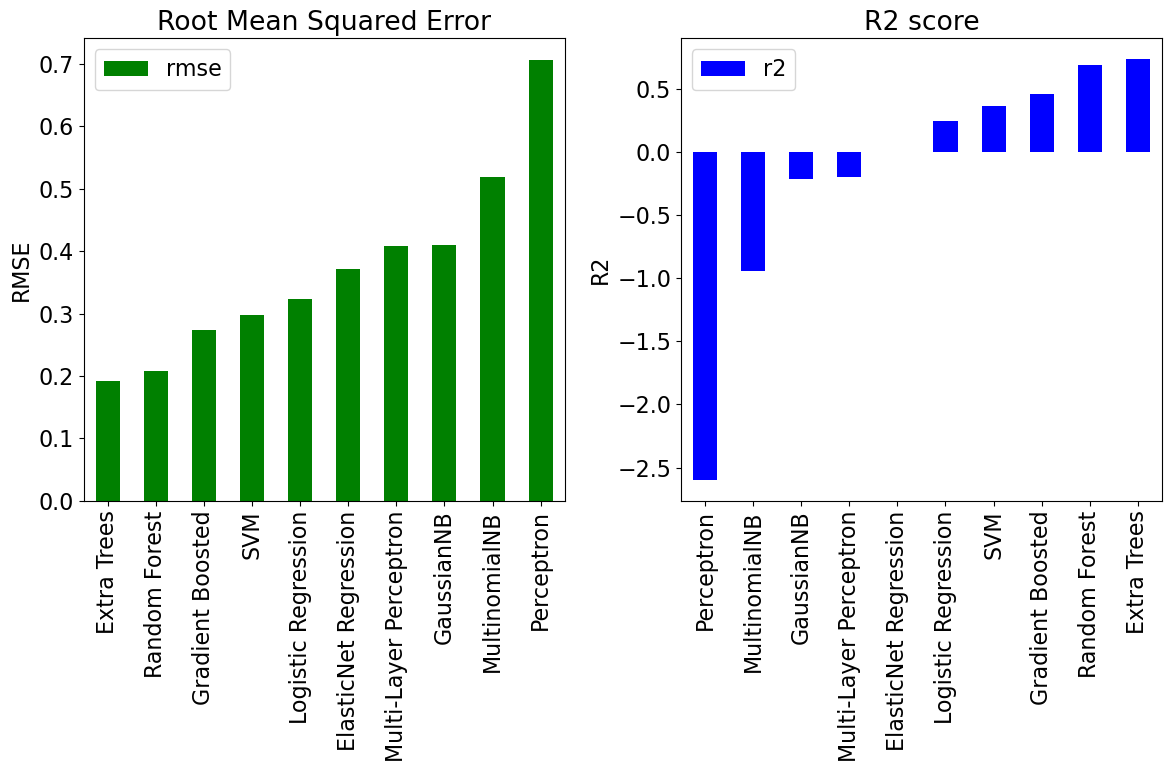

In [12]:
# plot the graph
figsize(12, 8)
plt.rcParams['font.size'] = 16
results = results[1:11]

# root mean squared error
ax = plt.subplot(1, 2, 1)
results.sort_values('rmse', ascending = True).plot.bar(y = 'rmse', color = 'g', ax = ax)
plt.title('Root Mean Squared Error'); plt.ylabel('RMSE');

# R2
ax = plt.subplot(1, 2, 2)
results.sort_values('r2', ascending = True).plot.bar(y = 'r2', color = 'b', ax = ax)
plt.title('R2 score'); plt.ylabel('R2');

plt.tight_layout()

### 4.2 KNN model with hyperparameter tuning and optimal tradeoff

In [14]:
%%time

warnings.filterwarnings('ignore')

# The param_grid tells Scikit-Learn to evaluate all combinations of the hyperparameter values
param_grid = {'n_neighbors': np.arange(1,10), 'p': [1, 2, 10], 'weights': ["uniform", "distance"]}

knn_clf = KNeighborsClassifier()

knn_cv = GridSearchCV(knn_clf, param_grid, scoring='f1', cv=2, verbose=3, n_jobs=-1)
knn_cv.fit(X_train.iloc[0:1000], y_train.iloc[0:1000])


params_optimal_knn = knn_cv.best_params_
print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal_knn)
print("\n")

knn = KNeighborsClassifier(**params_optimal_knn)
y_test_pred = cross_val_predict(knn, X_test, y_test, cv=2)
print("\n RMSE: ", math.sqrt(mean_squared_error(y_test_pred,y_test)))
print("confusion_matrix:", confusion_matrix(y_test, y_test_pred))
precision = precision_score(y_test, y_test_pred) 
print("Precision = %f" % precision)
recall = recall_score(y_test, y_test_pred)
print("Recall = %f" % recall)
f1 = f1_score(y_test, y_test_pred)
print("F1 Score = %f" % f1)
auc= roc_auc_score(y_test,y_test_pred)
print("AUC:",auc)
y_scores = cross_val_predict(knn, X_test, y_test, method="predict_proba", cv=2)[:, 1]
auc= roc_auc_score(y_test,y_scores)
print("AUC with predict_proba:",auc)

Fitting 2 folds for each of 54 candidates, totalling 108 fits
Best Score: 0.468750
Optimal Hyperparameter Values:  {'n_neighbors': 9, 'p': 2, 'weights': 'distance'}



 RMSE:  0.3602599534260687
confusion_matrix: [[752  32]
 [ 90  66]]
Precision = 0.673469
Recall = 0.423077
F1 Score = 0.519685
AUC: 0.6911302982731554
AUC with predict_proba: 0.7206959706959708
Wall time: 15min 55s


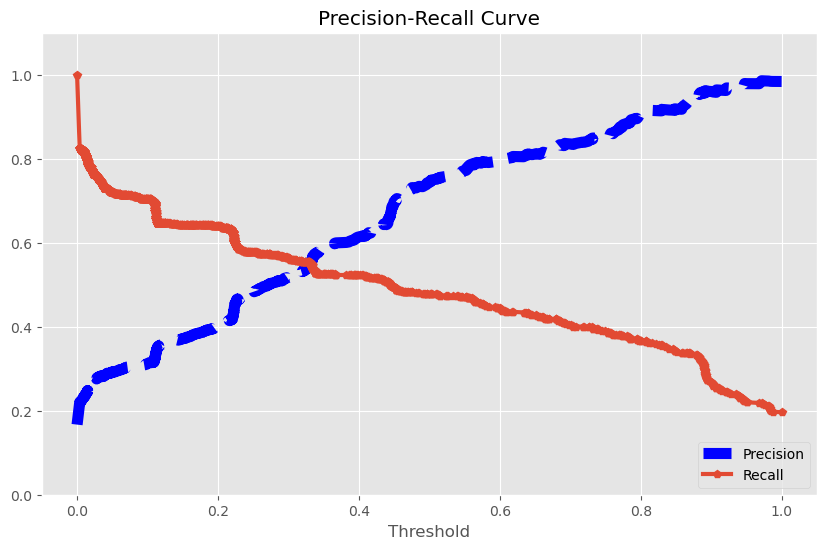

Optimal Threshold:  0.3313016237368413


In [15]:
# select the threshold value that gives the best precision/recall tradeoff for our problem

plt.style.use('ggplot')

# Get the 2nd column of the matrix of predicted probabilities for each data point
# The 2nd column stores the probalities of the positive class
y_scores = cross_val_predict(knn, X_train, y_train, method="predict_proba", cv=2)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_train, y_scores)

fig = plt.figure(figsize=(10, 6))
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--",  linewidth=8, label="Precision") 
    plt.plot(thresholds, recalls[:-1], "p-",  linewidth=3, label="Recall") 
    plt.xlabel("Threshold")
    plt.legend(loc="lower right")
    plt.title('Precision-Recall Curve')
    #plt.xlim([0, 1])
    plt.ylim([0, 1.1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

threshold_optimal = -1
for i in range(len(precisions)):
    if(precisions[i] == recalls[i]):
        threshold_optimal = thresholds[i]

print("Optimal Threshold: ", threshold_optimal)

## Part 5:  Unsupervised Learning Models for Classification

In [16]:
# data processing
data = pd.read_csv('test_celegans.csv', header=None)
data = data.sample(frac=1)
X, y = token_simple(data)

labels: (4696,)
dataset: (4696, 9107)
Number of positive/negative labels: 0    3913
1     783
Name: 2, dtype: int64


In [17]:
print(y.value_counts())

# Outlier
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=2)
y_pred = clf.fit_predict(X)
print((y_pred==1).sum(),(y_pred==-1).sum())
y_pred_update = np.where(y_pred==1,0,1)
print("LocalOutlierFactor result:", math.sqrt(mean_squared_error(y,y_pred_update)))

# KMeans
from sklearn.cluster import KMeans
y_pred =KMeans(n_clusters=2, random_state=0).fit(X).labels_
print((y_pred==1).sum(),(y_pred==0).sum())
y_pred_update = np.where(y_pred==1,0,1)
print("KMeans result:", math.sqrt(mean_squared_error(y,y_pred_update)))

0    3913
1     783
Name: 2, dtype: int64
3953 743
LocalOutlierFactor result: 0.5033956247580561
3217 1479
KMeans result: 0.6290118260751694


In [24]:
# Spectral Clustering
#from sklearn.cluster import SpectralClustering
#y_pred = SpectralClustering(n_clusters=2, random_state=0,assign_labels= 'cluster_qr', degree=1).fit(X).labels_
#print((y_pred==1).sum(),(y_pred==0).sum())
#y_pred_update = np.where(y_pred==1,0,1)
#print("Spectral Clustering result:", math.sqrt(mean_squared_error(y,y_pred_update)))

# Affinity Propagation
from sklearn.cluster import AffinityPropagation
af = AffinityPropagation(random_state=0).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
print((labels==1).sum(),(labels==-1).sum())
labels = np.where(labels==1,0,1)
n_clusters_ = len(cluster_centers_indices)
print("Affinity Propagation----Estimated number of clusters: %d" % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))

0 4696
Affinity Propagation----Estimated number of clusters: 0
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: -0.000
